# All Imports

In [1]:
# %%
import numpy as np
from matplotlib import pyplot as plt
import SimpleITK as sitk
import os
import cv2 as cv
from scipy import ndimage

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import SimpleITK as sitk
import numpy as np
import os
from pathlib import Path

# All Helper Functions

In [2]:
# %%
# Function to remove the CT bed in CT scans
def remove_ct_bed(ct_image, threshold=-300, erosion_radius=5):
    
    print("Removing CT bed...")
    
    # Convert to array
    ct_array = sitk.GetArrayFromImage(ct_image)
    
    # Threshold to get body (above threshold)
    body_binary = ct_array > threshold
    
    # Find largest connected component (assumes body is largest)
    from scipy import ndimage
    labeled, num_features = ndimage.label(body_binary)
    
    if num_features > 0:
        # Get sizes of all components
        sizes = ndimage.sum(body_binary, labeled, range(1, num_features + 1))
        # Keep only the largest component (the body)
        largest_component = np.argmax(sizes) + 1
        body_mask = (labeled == largest_component)
        
        # Morphological closing to fill holes
        struct = ndimage.generate_binary_structure(3, 2)
        body_mask = ndimage.binary_closing(body_mask, structure=struct, iterations=3)
        
        # Apply mask to CT
        ct_cleaned_array = ct_array.copy()
        ct_cleaned_array[~body_mask] = ct_array.min()  # Set background to minimum HU
    else:
        body_mask = body_binary
        ct_cleaned_array = ct_array
    
    # Convert back to SimpleITK image
    ct_cleaned = sitk.GetImageFromArray(ct_cleaned_array)
    ct_cleaned.CopyInformation(ct_image)
    
    body_mask_img = sitk.GetImageFromArray(body_mask.astype(np.uint8))
    body_mask_img.CopyInformation(ct_image)
    
    print(f"  Body volume: {body_mask.sum() / body_mask.size * 100:.1f}% of image")
    
    return ct_cleaned, body_mask_img

In [3]:
# Add notation here
def register_helper(fixed_image, moving_image):

    initial_transform = sitk.CenteredTransformInitializer(
        fixed_image,
        moving_image,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY,
    )

    min_value = float(sitk.GetArrayViewFromImage(moving_image).min())
    moving_resampled = sitk.Resample(
        moving_image,
        fixed_image,
        initial_transform,
        sitk.sitkLinear,
        min_value,
        moving_image.GetPixelID(),
    )

    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=1.0,
        numberOfIterations=100,
        convergenceMinimumValue=1e-6,
        convergenceWindowSize=10,
    )
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    final_transform = registration_method.Execute(
        sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32)
    )

    moving_resampled = sitk.Resample(
        moving_image,
        fixed_image,
        final_transform,
        sitk.sitkLinear,
        min_value,
        moving_image.GetPixelID(),
    )
    return moving_resampled

In [4]:
def preprocess_pipeline():
    """
    Complete preprocessing pipeline:
    1. Register MRI to CT
    2. Prune volumes to remove empty slices
    3. Histogram equalization
    4. Normalization
    5. Data augmentation
    """
    
    # Step 1: Registration
    print("Step 1: Registering MRI to CT...")
    registered_dir = "../HaN-Seg Registered"
    os.makedirs(registered_dir, exist_ok=True)
    
    for i in range(1, 43):
        case_num = f"{i:02d}"
        filepath_ct = f"../HaN-Seg/set_1/case_{case_num}/case_{case_num}_IMG_CT.nrrd"
        filepath_mri = f"../HaN-Seg/set_1/case_{case_num}/case_{case_num}_IMG_MR_T1.nrrd"
        ct = sitk.ReadImage(filepath_ct, sitk.sitkFloat32)
        mri = sitk.ReadImage(filepath_mri, sitk.sitkFloat32)
        
        mri_registered = register_helper(ct, mri)
        output_path = os.path.join(registered_dir, f"MRI_Case_{case_num}.nrrd")
        sitk.WriteImage(mri_registered, output_path)
    
    print("Registration complete!")
    
    # Step 2: Pruning
    print("Step 2: Pruning volumes...")
    pruned_dir = "../HaN-Seg Pruned"
    os.makedirs(os.path.join(pruned_dir, "MRI"), exist_ok=True)
    os.makedirs(os.path.join(pruned_dir, "GT"), exist_ok=True)
    
    for i in range(1, 43):
        case_num = f"{i:02d}"
        
        filepath_mri = os.path.join(registered_dir, f"MRI_Case_{case_num}.nrrd")
        mri = sitk.ReadImage(filepath_mri, sitk.sitkFloat32)
        mri = sitk.GetArrayViewFromImage(mri).astype(np.float32)

        filepath_gt = f"../HaN-Seg/set_1/case_{case_num}/case_{case_num}_OAR_Bone_Mandible.seg.nrrd"
        gt = sitk.ReadImage(filepath_gt, sitk.sitkFloat32)
        gt = sitk.GetArrayViewFromImage(gt).astype(np.float32)

        gt_var = np.var(gt, axis=(1, 2))
        mask = gt_var > 1e-10
        mri = mri[mask]
        mri = sitk.GetImageFromArray(mri)
        gt = gt[mask]
        gt = sitk.GetImageFromArray(gt)

        output_path = os.path.join(pruned_dir, "MRI", f"MRI_Case_{case_num}.nrrd")
        sitk.WriteImage(mri, output_path)

        output_path = os.path.join(pruned_dir, "GT", f"GT_Case_{case_num}.nrrd")
        sitk.WriteImage(gt, output_path)
    
    print("Pruning complete!")
    
    # Step 3: Histogram Equalization
    print("Step 3: Histogram equalization...")
    hist_eq_dir = "../HaN-Seg Hist Eq"
    os.makedirs(os.path.join(hist_eq_dir, "MRI"), exist_ok=True)
    os.makedirs(os.path.join(hist_eq_dir, "GT"), exist_ok=True)
    
    # Create reference histogram from first image
    reference_mri = sitk.ReadImage(f"{pruned_dir}/MRI/MRI_Case_01.nrrd", sitk.sitkFloat32)
    
    for i in range(1, 43):
        case_num = f"{i:02d}"
        filepath_mri = f"{pruned_dir}/MRI/MRI_Case_{case_num}.nrrd"
        mri = sitk.ReadImage(filepath_mri, sitk.sitkFloat32)
        
        matcher = sitk.HistogramMatchingImageFilter()
        matcher.SetNumberOfHistogramLevels(256)
        matcher.SetNumberOfMatchPoints(256)
        matcher.SetThresholdAtMeanIntensity(True)
        
        mri = matcher.Execute(mri, reference_mri)

        output_path = os.path.join(hist_eq_dir, "MRI", f"MRI_Case_{case_num}.nrrd")
        sitk.WriteImage(mri, output_path)
        
        # Copy GT (unchanged)
        filepath_gt = f"{pruned_dir}/GT/GT_Case_{case_num}.nrrd"
        gt = sitk.ReadImage(filepath_gt, sitk.sitkFloat32)
        output_path = os.path.join(hist_eq_dir, "GT", f"GT_Case_{case_num}.nrrd")
        sitk.WriteImage(gt, output_path)
    
    print("Histogram equalization complete!")
    
    # Step 4: Normalization
    print("Step 4: Normalizing...")
    normalized_dir = "../HaN-Seg Preprocessed"
    os.makedirs(os.path.join(normalized_dir, "MRI"), exist_ok=True)
    os.makedirs(os.path.join(normalized_dir, "GT"), exist_ok=True)
    
    # Calculate mean and std
    img_sum = 0.0
    img_sq_sum = 0.0
    total = 0
    for i in range(1, 43):
        case_num = f"{i:02d}"
        filepath = f"{hist_eq_dir}/MRI/MRI_Case_{case_num}.nrrd"
        mri = sitk.ReadImage(filepath, sitk.sitkFloat32)
        mri = sitk.GetArrayViewFromImage(mri).astype(np.float32)
        img_sum += np.sum(mri)
        img_sq_sum += np.sum(mri ** 2)
        total += mri.size
    
    train_mean = img_sum / total
    train_sd = np.sqrt(img_sq_sum / total - (train_mean ** 2))
    
    print(f"Dataset mean: {train_mean:.4f}, std: {train_sd:.4f}")

    for i in range(1, 43):
        case_num = f"{i:02d}"
        filepath = f"{hist_eq_dir}/MRI/MRI_Case_{case_num}.nrrd"
        mri = sitk.ReadImage(filepath, sitk.sitkFloat32)
        mri = sitk.GetArrayViewFromImage(mri).astype(np.float32)
    
        normalized = (mri - train_mean) / train_sd
        normalized = sitk.GetImageFromArray(normalized)
        output_path = os.path.join(normalized_dir, "MRI", f"MRI_Case_{case_num}.nrrd")
        sitk.WriteImage(normalized, output_path)
        
        # Copy GT (unchanged)
        filepath_gt = f"{hist_eq_dir}/GT/GT_Case_{case_num}.nrrd"
        gt = sitk.ReadImage(filepath_gt, sitk.sitkFloat32)
        output_path = os.path.join(normalized_dir, "GT", f"GT_Case_{case_num}.nrrd")
        sitk.WriteImage(gt, output_path)
    
    print("Normalization complete!")
    
    # Step 5: Data Augmentation
    print("Step 5: Data augmentation...")
    augmented_dir = "../HaN-Seg Augmented"
    os.makedirs(os.path.join(augmented_dir, "MRI"), exist_ok=True)
    os.makedirs(os.path.join(augmented_dir, "GT"), exist_ok=True)
    
    # Copy original data
    for i in range(1, 43):
        case_num = f"{i:02d}"
        
        mri = sitk.ReadImage(f"{normalized_dir}/MRI/MRI_Case_{case_num}.nrrd", sitk.sitkFloat32)
        gt = sitk.ReadImage(f"{normalized_dir}/GT/GT_Case_{case_num}.nrrd", sitk.sitkFloat32)
        
        # Original
        sitk.WriteImage(mri, f"{augmented_dir}/MRI/MRI_Case_{case_num}_orig.nrrd")
        sitk.WriteImage(gt, f"{augmented_dir}/GT/GT_Case_{case_num}_orig.nrrd")
        
        # Augmentation 1: Horizontal flip
        mri_flip = sitk.Flip(mri, [True, False, False])
        gt_flip = sitk.Flip(gt, [True, False, False])
        sitk.WriteImage(mri_flip, f"{augmented_dir}/MRI/MRI_Case_{case_num}_flip.nrrd")
        sitk.WriteImage(gt_flip, f"{augmented_dir}/GT/GT_Case_{case_num}_flip.nrrd")
        
        # Augmentation 2: Rotation (small angle)
        transform = sitk.Euler3DTransform()
        transform.SetCenter(mri.TransformContinuousIndexToPhysicalPoint(
            [(sz-1)/2.0 for sz in mri.GetSize()]))
        transform.SetRotation(0, 0, np.random.uniform(-0.1, 0.1))  # Small rotation around z-axis
        
        mri_rot = sitk.Resample(mri, transform, sitk.sitkLinear, 0.0)
        gt_rot = sitk.Resample(gt, transform, sitk.sitkNearestNeighbor, 0.0)
        sitk.WriteImage(mri_rot, f"{augmented_dir}/MRI/MRI_Case_{case_num}_rot.nrrd")
        sitk.WriteImage(gt_rot, f"{augmented_dir}/GT/GT_Case_{case_num}_rot.nrrd")
        
        # Augmentation 3: Gaussian noise
        noise_filter = sitk.AdditiveGaussianNoiseImageFilter()
        noise_filter.SetMean(0.0)
        noise_filter.SetStandardDeviation(0.05)
        mri_noise = noise_filter.Execute(mri)
        sitk.WriteImage(mri_noise, f"{augmented_dir}/MRI/MRI_Case_{case_num}_noise.nrrd")
        sitk.WriteImage(gt, f"{augmented_dir}/GT/GT_Case_{case_num}_noise.nrrd")  # GT unchanged
        
        # Augmentation 4: Intensity shift
        mri_arr = sitk.GetArrayFromImage(mri)
        shift = np.random.uniform(-0.1, 0.1)
        mri_shifted = sitk.GetImageFromArray(mri_arr + shift)
        mri_shifted.CopyInformation(mri)
        sitk.WriteImage(mri_shifted, f"{augmented_dir}/MRI/MRI_Case_{case_num}_shift.nrrd")
        sitk.WriteImage(gt, f"{augmented_dir}/GT/GT_Case_{case_num}_shift.nrrd")  # GT unchanged
    
    print(f"Data augmentation complete! Dataset size increased from 42 to {42*5} samples")
    print(f"Final preprocessed and augmented data saved to: {augmented_dir}")
    
    return train_mean, train_sd

In [5]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np

def visualize_augmented_case(case_num="01", slice_idx=None):
    """
    Visualize all augmentations for a single case
    
    Parameters:
    - case_num: Case number to visualize (e.g., "01", "15", "42")
    - slice_idx: Specific slice to show. If None, shows middle slice
    """
    
    augmented_dir = "../HaN-Seg Augmented"
    augmentation_types = ["orig", "flip", "rot", "noise", "shift"]
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle(f'Case {case_num} - All Augmentations', fontsize=16, fontweight='bold')
    
    for idx, aug_type in enumerate(augmentation_types):
        # Load MRI and GT
        mri_path = f"{augmented_dir}/MRI/MRI_Case_{case_num}_{aug_type}.nrrd"
        gt_path = f"{augmented_dir}/GT/GT_Case_{case_num}_{aug_type}.nrrd"
        
        mri = sitk.ReadImage(mri_path, sitk.sitkFloat32)
        gt = sitk.ReadImage(gt_path, sitk.sitkFloat32)
        
        mri_arr = sitk.GetArrayFromImage(mri)
        gt_arr = sitk.GetArrayFromImage(gt)
        
        # Get middle slice if not specified
        if slice_idx is None:
            slice_idx = mri_arr.shape[0] // 2
        
        # Display MRI (top row)
        axes[0, idx].imshow(mri_arr[slice_idx], cmap='gray')
        axes[0, idx].set_title(f'{aug_type.upper()} - MRI', fontsize=12)
        axes[0, idx].axis('off')
        
        # Display GT overlay (bottom row)
        axes[1, idx].imshow(mri_arr[slice_idx], cmap='gray')
        axes[1, idx].imshow(gt_arr[slice_idx], cmap='Reds', alpha=0.5)
        axes[1, idx].set_title(f'{aug_type.upper()} - GT Overlay', fontsize=12)
        axes[1, idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"\n=== Case {case_num} Statistics ===")
    print(f"Image shape: {mri_arr.shape}")
    print(f"Showing slice: {slice_idx}/{mri_arr.shape[0]}")
    print(f"MRI value range: [{mri_arr.min():.2f}, {mri_arr.max():.2f}]")
    print(f"GT value range: [{gt_arr.min():.2f}, {gt_arr.max():.2f}]")
    print(f"GT coverage: {(gt_arr > 0).sum() / gt_arr.size * 100:.2f}% of voxels")

# %%
def compare_augmentations_interactive(case_num="01"):
    """
    Interactive slider to browse through slices and compare augmentations
    """
    from ipywidgets import interact, IntSlider
    
    augmented_dir = "../HaN-Seg Augmented"
    
    # Load original to get dimensions
    mri_orig = sitk.ReadImage(f"{augmented_dir}/MRI/MRI_Case_{case_num}_orig.nrrd", sitk.sitkFloat32)
    mri_arr = sitk.GetArrayFromImage(mri_orig)
    num_slices = mri_arr.shape[0]
    
    def plot_slice(slice_idx):
        augmentation_types = ["orig", "flip", "rot", "noise", "shift"]
        
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        fig.suptitle(f'Case {case_num} - Slice {slice_idx}/{num_slices}', fontsize=16)
        
        for idx, aug_type in enumerate(augmentation_types):
            mri_path = f"{augmented_dir}/MRI/MRI_Case_{case_num}_{aug_type}.nrrd"
            gt_path = f"{augmented_dir}/GT/GT_Case_{case_num}_{aug_type}.nrrd"
            
            mri = sitk.GetArrayFromImage(sitk.ReadImage(mri_path, sitk.sitkFloat32))
            gt = sitk.GetArrayFromImage(sitk.ReadImage(gt_path, sitk.sitkFloat32))
            
            # MRI
            axes[0, idx].imshow(mri[slice_idx], cmap='gray')
            axes[0, idx].set_title(f'{aug_type.upper()}', fontsize=12)
            axes[0, idx].axis('off')
            
            # GT overlay
            axes[1, idx].imshow(mri[slice_idx], cmap='gray')
            axes[1, idx].imshow(gt[slice_idx], cmap='Reds', alpha=0.5)
            axes[1, idx].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Create interactive slider
    interact(plot_slice, slice_idx=IntSlider(min=0, max=num_slices-1, step=1, value=num_slices//2))

In [2]:
def load_images(img_path, mask_path):
    img_path = img_path.numpy().decode("utf-8")
    mask_path = mask_path.numpy().decode("utf-8")

    mri = sitk.ReadImage(img_path, sitk.sitkFloat32)
    gt = sitk.ReadImage(mask_path, sitk.sitkFloat32)

    slices = sitk.GetArrayViewFromImage(mri).astype(np.float32)
    slices_gt = sitk.GetArrayViewFromImage(gt).astype(np.float32)

    slices_resize = np.expand_dims(slices, axis=-1)
    slices_gt_resize = np.expand_dims(slices_gt, axis=-1)

    slices_resize = tf.image.resize(slices_resize, [IMAGE_RESIZE, IMAGE_RESIZE], method=tf.image.ResizeMethod.BILINEAR)
    slices_gt_resize = tf.image.resize(slices_gt_resize, [IMAGE_RESIZE, IMAGE_RESIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return slices_resize, slices_gt_resize

def lammy_func(img_path, mask_path):
    img, mask = tf.py_function(
        func=load_images,
        inp=[img_path, mask_path],
        Tout=[tf.float32, tf.float32]
    )
    img.set_shape([None, IMAGE_RESIZE, IMAGE_RESIZE, 1])
    mask.set_shape([None, IMAGE_RESIZE, IMAGE_RESIZE, 1])
    return img, mask

In [10]:
# Keep this handy cell in your notebook:
import importlib
import src.Helper_Functions
importlib.reload(src.Helper_Functions)
from src.Helper_Functions import *
print("Module reloaded!")

Module reloaded!


# Processing and Implementation

## Preprocessing

In [ ]:
# Preprocess all images (DON'T RUN! - we've already preprocessed)
train_mean, train_sd = preprocess_pipeline()

In [ ]:
import shutil

# Delete intermediate directories to free up space
shutil.rmtree("../HaN-Seg CT Cleaned", ignore_errors=True)
shutil.rmtree("../HaN-Seg Registered", ignore_errors=True)
shutil.rmtree("../HaN-Seg Pruned", ignore_errors=True)
shutil.rmtree("../HaN-Seg Hist Eq", ignore_errors=True)

In [ ]:
visualize_augmented_case(case_num="01")

In [ ]:
compare_augmentations_interactive(case_num="01")

## CNN Configuration

In [10]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000
RANDOM_SEED = 42
IMAGE_RESIZE = 1024

# Set random seeds
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU Available: []


In [ ]:
# Prepare file paths
train_img_path = []
train_gt_path = []

# Load augmented training data
augmentation_types = ["orig", "flip", "rot", "noise", "shift"]
for i in range(1, 43):
    case_num = f"{i:02d}"
    for aug_type in augmentation_types:
        filepath_mri = f"../HaN-Seg Augmented/MRI/MRI_Case_{case_num}_{aug_type}.nrrd"
        filepath_gt = f"../HaN-Seg Augmented/GT/GT_Case_{case_num}_{aug_type}.nrrd"
        train_img_path.append(filepath_mri)
        train_gt_path.append(filepath_gt)

# Load non-augmented data for validation/test
val_test_img_path = []
val_test_gt_path = []

for i in range(1, 43):
    case_num = f"{i:02d}"
    filepath_mri = f"../HaN-Seg Preprocessed/MRI/MRI_Case_{case_num}.nrrd"
    filepath_gt = f"../HaN-Seg Preprocessed/GT/GT_Case_{case_num}.nrrd"
    val_test_img_path.append(filepath_mri)
    val_test_gt_path.append(filepath_gt)

# Split validation/test
X_val, X_test, y_val, y_test = train_test_split(
    val_test_img_path, val_test_gt_path, 
    test_size=0.3, 
    random_state=RANDOM_SEED
)

print(f"Training volumes (augmented): {len(train_img_path)}")
print(f"Validation volumes: {len(X_val)}")
print(f"Test volumes: {len(X_test)}")

Training volumes (augmented): 210
Validation volumes: 21
Test volumes: 21


In [12]:
# Generator functions
def data_generator(img_paths, gt_paths, batch_size, shuffle=True):
    """Generator that yields batches of 2D slices"""
    indices = np.arange(len(img_paths))
    
    while True:
        if shuffle:
            np.random.shuffle(indices)
        
        batch_mri = []
        batch_gt = []
        
        for idx in indices:
            # Load volume
            mri = sitk.ReadImage(img_paths[idx], sitk.sitkFloat32)
            mri_arr = sitk.GetArrayFromImage(mri).astype(np.float32)
            
            gt = sitk.ReadImage(gt_paths[idx], sitk.sitkFloat32)
            gt_arr = sitk.GetArrayFromImage(gt).astype(np.float32)
            gt_arr = (gt_arr > 0).astype(np.float32)
            
            # Yield slices from this volume
            for slice_idx in range(mri_arr.shape[0]):
                batch_mri.append(mri_arr[slice_idx][..., np.newaxis])
                batch_gt.append(gt_arr[slice_idx][..., np.newaxis])
                
                # When batch is full, yield it
                if len(batch_mri) == batch_size:
                    yield np.array(batch_mri), np.array(batch_gt)
                    batch_mri = []
                    batch_gt = []
        
        # Yield remaining samples if any
        if len(batch_mri) > 0:
            yield np.array(batch_mri), np.array(batch_gt)

# Calculate steps per epoch (approximate)
def calculate_steps(img_paths, batch_size):
    """Estimate number of steps per epoch"""
    total_slices = 0
    # Sample first few volumes to estimate average number of slices
    sample_size = min(5, len(img_paths))
    for i in range(sample_size):
        mri = sitk.ReadImage(img_paths[i], sitk.sitkFloat32)
        total_slices += sitk.GetArrayFromImage(mri).shape[0]
    
    avg_slices_per_volume = total_slices / sample_size
    estimated_total_slices = int(avg_slices_per_volume * len(img_paths))
    steps = estimated_total_slices // batch_size
    
    return steps

train_steps = calculate_steps(train_img_path, BATCH_SIZE)
val_steps = calculate_steps(X_val, BATCH_SIZE)

print(f"\nEstimated steps per epoch:")
print(f"  Training: {train_steps}")
print(f"  Validation: {val_steps}")

# Create generators
train_gen = data_generator(train_img_path, train_gt_path, BATCH_SIZE, shuffle=True)
val_gen = data_generator(X_val, y_val, BATCH_SIZE, shuffle=False)
test_gen = data_generator(X_test, y_test, BATCH_SIZE, shuffle=False)


Estimated steps per epoch:
  Training: 564
  Validation: 47


Testing generator...
Batch shape - MRI: (16, 1024, 1024, 1), GT: (16, 1024, 1024, 1)


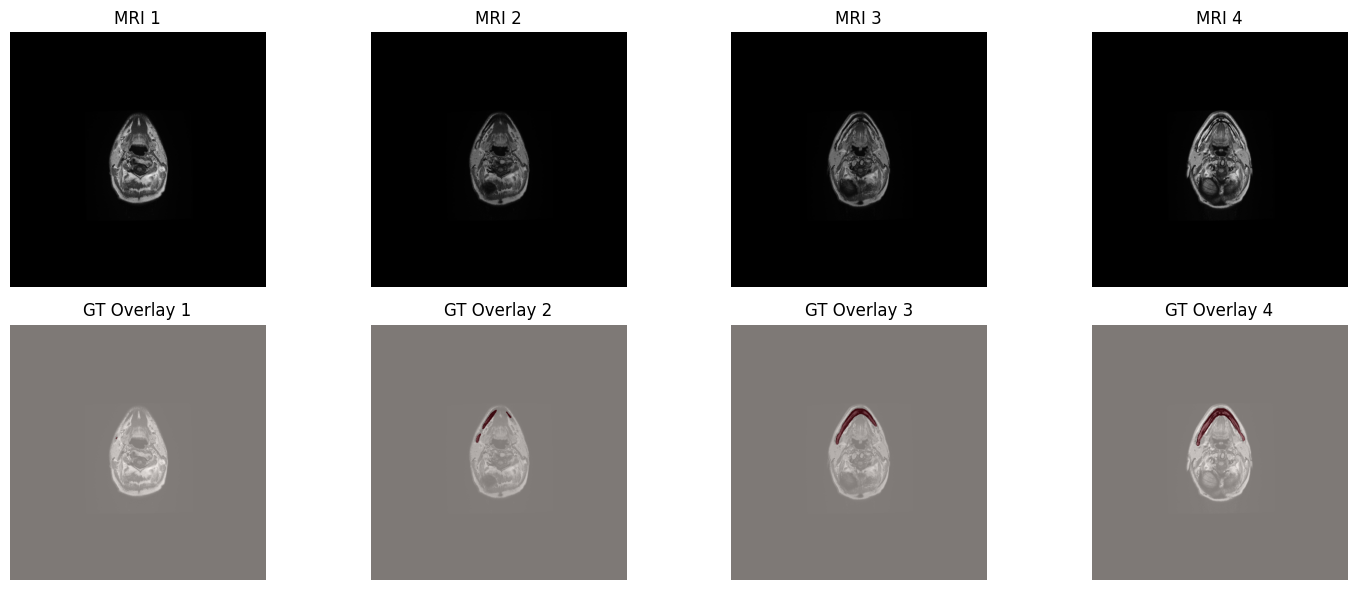

In [13]:
# Verify generator works
print("Testing generator...")
sample_mri, sample_gt = next(train_gen)
print(f"Batch shape - MRI: {sample_mri.shape}, GT: {sample_gt.shape}")

# Visualize
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(15, 6))
for i in range(4):
    axes[0, i].imshow(sample_mri[i, :, :, 0], cmap='gray')
    axes[0, i].set_title(f'MRI {i+1}')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(sample_mri[i, :, :, 0], cmap='gray')
    axes[1, i].imshow(sample_gt[i, :, :, 0], cmap='Reds', alpha=0.5)
    axes[1, i].set_title(f'GT Overlay {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Reset generator
train_gen = data_generator(train_img_path, train_gt_path, BATCH_SIZE, shuffle=True)
val_gen = data_generator(X_val, y_val, BATCH_SIZE, shuffle=False)

In [14]:
## A single Encoding step in the Contracting path of a U-Net CNN
## @Inputs:
##       inputs: image of size (nxn) with k feature channels
##       num_channels: number of channels to have in output image (i.e. depth of output tensor)
## @Outputs: 
##       x: image of size (n/2 x n/2) with num_channels feature channels
def encode_block(inputs, num_channels):
    # Extract num_channels feature channels from image
    x = tf.keras.layers.Conv2D(num_channels, 3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(num_channels, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    skip = tf.keras.layers.Activation('relu')(x)

    # Downsample each channels feature map by a factor of 2
    x = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(skip)

    return skip, x

## A single Decoding step in the Expanding path of a U-Net CNN
## @Inputs:
##       inputs: image of size (nxn) with k feature channels
##       skip_connection: tensor of corresponding encoding block
##       num_channels: number of channels to have in output image (i.e. depth of output tensor)
## @Outputs: 
##       x: image of size (2nx2n) with num_channels feature channels
def decode_block(inputs, skip_connection, num_channels):
    # Upsample image by doubling feature space while changing feature channels to num_channels
    x = tf.keras.layers.Conv2DTranspose(num_channels, (2,2), strides=2, padding='same')(inputs)

    # Concatonate the skip_channel and the upsampled image (doubles the feature channels)
    # Might need to resize skip_connection, but should be fine b/c same padding in encoding
    x = tf.keras.layers.Concatenate()([x, skip_connection])
    
    # Merge feature channels from the skip_connection and upsampled input image
    x = tf.keras.layers.Conv2D(num_channels, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(num_channels, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

# Metrics
# Source: https://medium.com/mastering-data-science/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f
def dice_coeff(y_true, y_pred):
    epsilon = 1e-6
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))
    return (2*tp+epsilon)/(2*tp + fp + fn+epsilon)

def rand_index(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))
    return tp / (tp + fp + fn)

def jaccard_index(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))
    tn = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred), tf.float32))
    return (tp + tn) / (tp + tn + fn + fp)

def specificity(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    true_negatives = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred), tf.float32))
    possible_negatives = tf.reduce_sum(tf.cast(1 - y_true, tf.float32))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

def custom_loss(y_true, y_pred):
    dice_weight = 10.0
    bce_weight = 1.0
    bce = tf.keras.losses.BinaryCrossentropy()
    loss_dice = 1.0 - dice_coeff(y_true, y_pred)
    loss_bce = bce(y_true, y_pred)
    loss = dice_weight * loss_dice + bce_weight * loss_bce

    tf.print("BCE:", loss_bce, "Dice loss:", loss_dice)
    return loss

In [ ]:
# Build U-Net Model
input_layer = tf.keras.layers.Input(shape=(IMAGE_RESIZE, IMAGE_RESIZE, 1))

s1, e1 = encode_block(input_layer, 32)
s2, e2 = encode_block(e1, 64)
s3, e3 = encode_block(e2, 128)
s4, e4 = encode_block(e3, 256)
s5, e5 = encode_block(e4, 512)

# Bottleneck
b1 = tf.keras.layers.Conv2D(1024, 3, padding='same')(e5)
b1 = tf.keras.layers.Activation('relu')(b1)
b1 = tf.keras.layers.Conv2D(1024, 3, padding='same')(b1)
b1 = tf.keras.layers.Activation('relu')(b1)

# Decoder
d1 = decode_block(b1, s5, 512)
d2 = decode_block(d1, s4, 256)
d3 = decode_block(d2, s3, 128)
d4 = decode_block(d3, s2, 64)
d5 = decode_block(d4, s1, 32)

output = tf.keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(d5)

model = tf.keras.models.Model(inputs=input_layer, outputs=output, name='U-Net')

model.compile(
    optimizer='adam',
    loss=custom_loss,
    metrics=['accuracy', dice_coeff, specificity, rand_index, jaccard_index]
)

model.summary()

In [16]:
# Train the model
EPOCHS = 4

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_dice_coeff',
    patience=10,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_unet_model.h5',
    monitor='val_dice_coeff',
    mode='max',
    save_best_only=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_dice_coeff',
    factor=0.5,
    patience=5,
    mode='max',
    verbose=1
)

history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/4
BCE: 0.788601518 Dice loss: 0.990538955


: 